[Ссылка на репозиторий](https://github.com/valery-v-ya/first-progect)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Целью данного проекта является - прогнозирование того, уйдёт клиент из банка в ближайшее время или нет.
Для достижения данной цели в ходе реализации проекта требуется:
1. Подготовить данные. Рассмотреть их на наличение аномалий, пропущенных значений или дубликатов. 
2. Рассмотреть являются ли все столбцы информативными для обучения модели, если нет - удалить лишнии столбцы.
3. Рассмотреть баланс классов.
4. Определить target.Разделить данные на тренировочные, тестовые и валидационные.
5. Рассмотреть различные значения класов, определить, какие преобразования к ним более корректно применить.Преобразовать данные с помощью One-Hot Encoding и standardScaler.
6. Обучить несколько моделей на неуравновешенных данных. Подобрать гиперпараметры.
7. Уравновесить классы с использованием апсемплинга и даунсемплинга.
8. Обучить несколько моделей на уравновешенных данных, получить точность больше 0.59
9. Измерить AUC-ROC и сравнить с F1-мерой.

In [1]:
! pip install imblearn

     |████████████████████████████████| 226 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 81.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import warnings

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Подготовка данных

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Тут мы видим, что есть около 10% пропущенных значений в столбце "Tenure", т.к данный столбик это значение того, сколько лет человек является клиентом банка, скорей всего пропущенное значение значит, что клиент меньше одного года яаляется клиентом банка, заполним пропущенные значения 0, т.к то, что клиент пользуется банком меньше года тоже информативная информация. Возможно это просто пропущенные значения, если бы это была реальная продуктовая задача, я бы уточнила этот момент у менеджера.

In [6]:
data['Tenure'] = data['Tenure'].fillna(0)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Больше пропущенных значений нет

In [8]:
# Проверим наличие явных дубликатов в данных
data.duplicated().sum()

0

Явных дубликатов в данных нет

Проверим некоторые стобцы на очевидные аномалии:
1. Проверим уникальные значения в столбце "Gender"
2. Выведим минимальное и максимальное значения возрастов
3. Проверим, что возраст человека всегда больше, чем на 6 лет больше, чем количество лет, которое он пользуется картой
4. Хотелось бы еще проверить аномалии в стобце с кредитным рейтингом, но об том, каким он может быть ничего не сказано, к сожалению

In [9]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

В стобце Gender встречаются только два типа данных, что соответсвует описанию стобца

In [10]:
data['Age'].min()

18

In [11]:
data['Age'].max()

92

Данные в стобце с возрастом также не имеют возрастных аномалий или выбросов

In [12]:
data['check'] = ((data['Tenure'] + 6) <= data['Age'])

In [13]:
len(data[data['check'] == False])

0

Все данные соответсвуют требованию, что человек больше, чем на 6 лет страшне, чем его время пользования картой

Чтобы понимать, какие столбцы кодировать каким методом, нам нужно понимать разнообразие данных в этих столбцах, поэтому выведем максимальные значения или длину уникальных значений стобцов NumOfProducts, Tenure и Geography.

In [14]:
data['NumOfProducts'].max()

4

In [15]:
data['Tenure'].max()

10.0

In [16]:
len(data['Tenure'].unique())

11

In [17]:
data = data.drop(['check', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

Удалили лишний столбик с проверкой, проверили, что с таблицей все нормально.
Удалили неинформативные стобцы, которые являются признаками отдельного пользователя, а не фичами для последущей работы модели

Как мы видим в данных нет пропусков, дубликатов и каких-то аномалий, поэтому можно переходить к работе с данными.

Разделим данные на features и target. По заданию мы должны предсказать уйдет клиент из банка или нет, т.е наш taget - это столбец "Exited", а все остальные стобцы это фичи. 

Разобьем данные на тренировочные и тестовые.
Также удалим из таблицы те признаки, которые мы преобразовали с использованием One-Hot Encoding.

In [23]:
features = data.drop('Exited', axis=1)
target = data['Exited']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1024)

In [25]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1024)

In [26]:
X, y = pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid])

In [27]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop="first").fit(X_train[['Geography', 'Gender']])

In [28]:
X_train = X_train.join(pd.DataFrame(
    enc.transform(X_train[['Geography','Gender']]),
    columns=enc.get_feature_names_out(),
    index=X_train.index,
))

In [29]:
X_test = X_test.join(pd.DataFrame(
    enc.transform(X_test[['Geography','Gender']]),
    columns=enc.get_feature_names_out(),
    index=X_test.index,
))

In [30]:
X_valid = X_valid.join(pd.DataFrame(
    enc.transform(X_valid[['Geography','Gender']]),
    columns=enc.get_feature_names_out(),
    index=X_valid.index,
))

In [31]:
X_train = X_train.drop(['Geography','Gender'], axis=1)
X_test = X_test.drop(['Geography','Gender'], axis=1)
X_valid = X_valid.drop(['Geography','Gender'], axis=1)

In [32]:
scale_columns_minmax = ["CreditScore", "Tenure"]
scale_columns_standard = ["Age", "Balance", 'EstimatedSalary']

In [33]:
scaler_minmax = MinMaxScaler().fit(X_train[scale_columns_minmax])
scaler_standard = StandardScaler().fit(X_train[scale_columns_standard])

In [34]:
X_train[scale_columns_minmax] = scaler_minmax.transform(X_train[scale_columns_minmax])

In [35]:
X_train[scale_columns_standard] = scaler_standard.transform(X_train[scale_columns_standard])

In [36]:
X_test[scale_columns_minmax] = scaler_minmax.transform(X_test[scale_columns_minmax])

In [37]:
X_test[scale_columns_standard] = scaler_standard.transform(X_test[scale_columns_standard])

In [38]:
X_valid[scale_columns_minmax] = scaler_minmax.transform(X_valid[scale_columns_minmax])

In [39]:
X_valid[scale_columns_standard] = scaler_standard.transform(X_valid[scale_columns_standard])

## Исследование задачи

Чтобы оценить, на сколько соотношение классов сбалансировано между собой посчитаем количество 0 и 1 классах в наших данных.

In [40]:
print('Класс 0 -', sum(y_train == 0) / len(y_train), 'Класс 1 -', sum(y_train == 1) / len(y_train))

Класс 0 - 0.7944285714285715 Класс 1 - 0.20557142857142857


In [41]:
proportion = (sum(y_train == 0) / len(y_train)) / (sum(y_train == 1) / len(y_train))
proportion, fraction = int(proportion) + 1, 1 / proportion, 
proportion, fraction

(4, 0.2587664089192591)

Тут мы видим, что объектов нулевого класса существенно больше, чем первого. И это нужно будет уровновестить.

Обучим три модели и подберем для них оптимальные гиперпараметры.

In [42]:
model_des_tree = DecisionTreeClassifier(random_state=1024)
parameters_1 = {'max_depth': [5, 10, 25, 50], 'criterion': ["gini", "entropy", "log_loss"]}
GSCV_tree = GridSearchCV(model_des_tree, parameters_1, scoring="f1")
GSCV_tree.fit(X_train, y_train)
pred_tree = GSCV_tree.predict(X_valid)
y_pred_proba_tree = GSCV_tree.predict_proba(X_valid)[:,1]


print("F1:", f1_score(y_valid, pred_tree))
print('AUC:', roc_auc_score(y_valid, y_pred_proba_tree))

F1: 0.551984877126654
AUC: 0.8120241443171685


In [43]:
model_random_forest = RandomForestClassifier(random_state=1024)
parameters_2 = {
    'n_estimators': [5, 25, 50, 100, 150], 
    'max_depth': [5, 10, 15, 25],
    'criterion': ['gini', 'entropy', 'log_loss'],
}
GSCV_forest = GridSearchCV(model_random_forest, parameters_2, scoring="f1")
GSCV_forest.fit(X_train, y_train)
pred_forest = GSCV_forest.predict(X_valid)
y_pred_proba_forest = GSCV_forest.predict_proba(X_valid)[:,1]


print("F1:", f1_score(y_valid, pred_forest))
print('AUC:', roc_auc_score(y_valid, y_pred_proba_forest))

F1: 0.5594989561586639
AUC: 0.8582659990397147


In [44]:
model_log_reg = LogisticRegression(random_state=1024, solver='lbfgs')
parameters_3 = {'max_iter': [5, 7, 10, 15, 25, 50]}
GSCV_log_reg = GridSearchCV(model_log_reg, parameters_3, scoring="f1")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    GSCV_log_reg.fit(X_train, y_train)
    
pred_log_reg = GSCV_log_reg.predict(X_valid)
y_pred_proba_log_reg = GSCV_forest.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_log_reg))
print('AUC:', roc_auc_score(y_valid, y_pred_proba_log_reg))

F1: 0.3509615384615385
AUC: 0.8582659990397147


Мы обучили три модели на несбалансированных данных, даже при таких данных модель случаного леса показала результат 0.55, что является лучшим из трех результатов. Дерево решений показло результат 0.54, а логистическая регрессия 0.47. 

## Борьба с дисбалансом

В задании требуется попробовать несколько методов борьбы с дисбалансом классов. Попробуем использовать апсемплинг и даунсемплинг.

In [45]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [46]:
X_upsampled_train, y_upsampled_train = upsample(X_train, y_train, repeat=proportion)

In [47]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [48]:
X_downsampled, y_downsampled = downsample(X_train, y_train, fraction=fraction)

Теперь снова обучим модели из предыдущего раздела, только на уравновещенных данных и посмотрим, как изменились результаты.

In [49]:
sm = SMOTE(random_state=1024)
X_res_sm, y_res_sm = sm.fit_resample(X_train, y_train)

In [50]:
rus = RandomUnderSampler(random_state=1024)
X_res_un, y_res_un = rus.fit_resample(X_train, y_train)

In [51]:
GSCV_tree_un = GridSearchCV(model_des_tree, parameters_1, scoring="f1")
GSCV_tree_un.fit(X_res_un, y_res_un)
pred_tree_un = GSCV_tree_un.predict(X_valid)
y_proba_pred_tree_un = GSCV_tree_un.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_tree_un))
print('AUC:', roc_auc_score(y_valid, y_proba_pred_tree_un))

F1: 0.5551020408163266
AUC: 0.8289951299814803


In [52]:
GSCV_tree_sm = GridSearchCV(model_des_tree, parameters_1, scoring="f1")
GSCV_tree_sm.fit(X_res_sm, y_res_sm)
pred_tree_sm = GSCV_tree_sm.predict(X_valid)
y_proba_pred_tree_sm = GSCV_tree_sm.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_tree_sm))
print('AUC:', roc_auc_score(y_valid, y_proba_pred_tree_sm))

F1: 0.48164464023494863
AUC: 0.6801495301461005


In [53]:
GSCV_forest_un = GridSearchCV(model_random_forest, parameters_2, scoring="f1")
GSCV_forest_un.fit(X_res_un, y_res_un)
pred_forest_un = GSCV_forest_un.predict(X_valid)
y_proba_pred_forest_un = GSCV_forest_un.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_forest_un))
print('AUC:', roc_auc_score(y_valid, y_proba_pred_forest_un))

F1: 0.5924932975871313
AUC: 0.855600521297757


In [54]:
GSCV_forest_sm = GridSearchCV(model_random_forest, parameters_2, scoring="f1")
GSCV_forest_sm.fit(X_res_sm, y_res_sm)
pred_forest_sm = GSCV_forest_sm.predict(X_valid)
y_proba_pred_forest_sm = GSCV_forest_sm.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_forest_sm))
print('AUC:', roc_auc_score(y_valid, y_proba_pred_forest_sm))

F1: 0.6030150753768845
AUC: 0.8496069689279099


In [55]:
hgbc_params = {
    "max_depth": [5, 10, 15, 25, 50, None],
    "min_samples_leaf": [5, 10, 15, 20],
    "max_leaf_nodes": [10, 25, 50, None],
    "max_iter": [50, 100, 250],
}
hgbc = HistGradientBoostingClassifier(random_state=1024, scoring="f1")
hgbc_sm = GridSearchCV(hgbc, hgbc_params, scoring="f1")
hgbc_sm.fit(X_res_sm, y_res_sm)
pred_hgbc = hgbc_sm.predict(X_valid)
y_proba_hgbc = hgbc_sm.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_hgbc))
print('AUC:', roc_auc_score(y_valid, y_proba_hgbc))

F1: 0.5723905723905724
AUC: 0.8340544618972494


In [56]:
hgbc_params = {
    "max_depth": [10, 15, 25, None],
    "min_samples_leaf": [5, 10, 15, 20],
    "max_leaf_nodes": [10, 25, 50, None],
    "max_iter": [50, 250, 750, 1500],
}
hgbc = HistGradientBoostingClassifier(random_state=1024, scoring="f1")
hgbc_sm = GridSearchCV(hgbc, hgbc_params, scoring="f1")
hgbc_sm.fit(X_res_un, y_res_un)
pred_hgbc = hgbc_sm.predict(X_valid)
y_proba_hgbc = hgbc_sm.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_hgbc))
print('AUC:', roc_auc_score(y_valid, y_proba_hgbc))

F1: 0.5877659574468085
AUC: 0.8566993620961658


In [57]:
GSCV_log_reg_un = GridSearchCV(model_log_reg, parameters_3, scoring="f1")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    GSCV_log_reg_un.fit(X_res_un, y_res_un)
    
pred_log_reg_un = GSCV_log_reg_un.predict(X_valid)
y_proba_pred_log_reg_un = GSCV_log_reg_un.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_log_reg_un))
print('AUC:', roc_auc_score(y_valid, y_proba_pred_log_reg_un))

F1: 0.49696969696969695
AUC: 0.7623430962343096


In [58]:
GSCV_log_reg_sm = GridSearchCV(model_log_reg, parameters_3, scoring="f1")

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    GSCV_log_reg_sm.fit(X_res_sm, y_res_sm)
    
pred_log_reg_sm = GSCV_log_reg_sm.predict(X_valid)
y_proba_pred_log_reg_sm = GSCV_forest_sm.predict_proba(X_valid)[:,1]

print("F1:", f1_score(y_valid, pred_log_reg_sm))
print('AUC:', roc_auc_score(y_valid, y_proba_pred_log_reg_sm))

F1: 0.4903381642512078
AUC: 0.8496069689279099


Как мы видим результаты работы всех моделей улучшались, одна из моделей перешла установленный в задании порог. 

Возьмем модель с самым лучшим результатом, посчитаем для нее AUC и построем Roc-кривую.

In [59]:
y_pred_proba_last = GSCV_forest_sm.predict_proba(X_test)[:,1]
pred_last = GSCV_forest_sm.predict(X_test)

In [60]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_last)

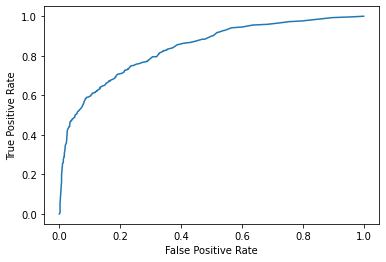

In [61]:
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
auc = roc_auc_score(y_test, y_pred_proba_last)

In [63]:
print('AUC лучшей модели =', auc)

AUC лучшей модели = 0.8391267096657439


In [64]:
print("F1 лучшей модели =", f1_score(y_test, pred_last))

F1 лучшей модели = 0.6000000000000001


В результате мы видим достаточно высокую точность, как самой лучшей модели, так и модели, которая показала самые слабые результаты.
В ходе выполнения работы мы прогнозировали то, уйдёт клиент из банка в ближайшее время или нет. Для решений этой задачи были подготовлены данные, рассмотрены и устранены проблемы с дисбалансом классов, рассмотрены и преобразованы данные с использованием One-Hot Encoding и Scaler, данные были подготовлены для обучения моделей, после чего были обучены три модели, которые показали неплохие результаты даже на несбалансированных данных, после чего данные были сбалансированы и модели были обучены снова. По результатом обучения всех моделей были выбраны две модели с лучшими и худшими результатами и для них были построены roc-кривык и посчитан auc.